In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import numpy as np

In [ ]:
df = pd.read_csv('orders_train.txt', sep=';')
print('Number of records between {} to {}: {}'.format(df['orderDate'].iloc[0], df['orderDate'].iloc[-1], len(df)))
print('Number of attributes corresponding to a single record {}:'.format(df.shape[1]-1))
df.head()

Number of records between 2014-01-01 to 2015-09-30: 2325165
Number of attributes corresponding to a single record 14:


,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,0.0,c1010575,2,BPRG,0
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,0.0,c1010575,2,BPRG,0
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,0.0,c1045905,4,BPRG,0
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,0.0,c1045905,4,BPRG,1
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,0.0,c1089295,2,PAYPALVC,0


In [ ]:
#check NA values
print(df.isna().sum())
#drop d values since not a significant number of records contain NA
df = df.dropna()

## inconsistent records
drop_idx = df[(df['quantity']==0) |  (df['price']==0) | (df['quantity']<df['returnQuantity']) ].index
df = df.drop(drop_idx)
df.shape


orderID             0
orderDate           0
articleID           0
colorCode           0
sizeCode            0
productGroup      351
quantity            0
price               0
rrp               351
voucherID           6
voucherAmount       0
customerID          0
deviceID            0
paymentMethod       0
returnQuantity      0
dtype: int64


(2277968, 15)

In [ ]:
# Aggregate features by 'orderID'
order_agg = df.groupby('orderID').agg(total_quantity=('quantity', 'sum'),
                                        total_price=('price', 'sum'),
                                        mean_rrp=('rrp', 'mean')).reset_index()

# Merge back to the original data
df = df.merge(order_agg, on='orderID', how='left')

# Aggregate features by 'customerID'
customer_agg = df.groupby('customerID').agg(total_orders=('orderID', 'nunique'),
                                               mean_quantity_per_order=('quantity', 'mean')).reset_index()

# Merge back to the original data
df = df.merge(customer_agg, on='customerID', how='left')

# Aggregate features by 'articleID'
article_agg = df.groupby('articleID').agg(mean_price=('price', 'mean'),
                                            mean_rrp=('rrp', 'mean')).reset_index()

# Merge back to the original data
df = df.merge(article_agg, on='articleID', how='left')


In [ ]:
df.head()

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,...,deviceID,paymentMethod,returnQuantity,total_quantity,total_price,mean_rrp_x,total_orders,mean_quantity_per_order,mean_price,mean_rrp_y
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,...,2,BPRG,0,2,30.00,34.99,2,1.0,10.000000,29.99
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,...,2,BPRG,0,2,30.00,34.99,2,1.0,17.617925,39.99
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,...,4,BPRG,0,2,84.99,49.99,1,1.0,26.563545,49.99
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,...,4,BPRG,1,2,84.99,49.99,1,1.0,35.045073,49.99
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,...,2,PAYPALVC,0,4,60.00,37.99,1,1.0,10.026178,35.99


In [ ]:
df['colorCode_1'] = df['colorCode'].apply(lambda x: int(str(x)[0]))
df['colorCode_2'] = df['colorCode'].apply(lambda x: int(str(x)[1]))
df['colorCode_3'] = df['colorCode'].apply(lambda x: int(str(x)[2]))
df['colorCode_4'] = df['colorCode'].apply(lambda x: int(str(x)[3]))

In [ ]:
# Likelihood of returning for each customer
returns_agg = df.groupby('customerID').agg(
    total_returned=('returnQuantity', 'sum'),
    total_ordered=('quantity', 'sum')
).reset_index()
returns_agg['likelihood_of_returning'] = returns_agg['total_returned'] / returns_agg['total_ordered']
df = df.merge(returns_agg[['customerID', 'likelihood_of_returning']], on='customerID', how='left')

# Item similarity within orders (simple example based on articleID)
df['similar_items_in_order'] = df.groupby(['orderID', 'articleID'])['quantity'].transform('sum')

In [ ]:
df[['customerID', 'likelihood_of_returning', 'orderID', 'articleID', 'similar_items_in_order']].head()

,customerID,likelihood_of_returning,orderID,articleID,similar_items_in_order
0,c1010575,0.0,a1000001,i1000382,1
1,c1010575,0.0,a1000001,i1000550,1
2,c1045905,0.5,a1000002,i1001991,1
3,c1045905,0.5,a1000002,i1001999,1
4,c1089295,0.0,a1000003,i1001942,2


In [ ]:
len(df.columns)

28

In [ ]:
# Price level categorization based on rrp
bins = [0, 20, 50, 100, float('inf')]  # Define bins for price levels
labels = ['cheap', 'regular', 'expensive', 'luxury']
df['price_level'] = pd.cut(df['rrp'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
df[['productGroup', 'deviceID']] = df[['productGroup', 'deviceID']].astype(str)
df['price_level'] = df['price_level'].astype(str)

In [ ]:
# Define columns for one-hot encoding
OHE_feats = ['productGroup', 'deviceID', 'paymentMethod','price_level']

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(df[OHE_feats])

# Create DataFrame with one-hot encoded features
df_OHE = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(OHE_feats))

# Reset indices of the original data and df_OHE to ensure they are aligned
df.reset_index(drop=True, inplace=True)
df_OHE.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from 'data'
df.drop(columns=OHE_feats, inplace=True)

# Concatenate the one-hot encoded DataFrame columns to the original DataFrame
data = pd.concat([df, df_OHE], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
data.drop(columns=[
    'paymentMethod_BPPL', 'paymentMethod_CBA',
    'paymentMethod_KGRG', 'paymentMethod_KKE', 'paymentMethod_NN',
    'paymentMethod_PAYPALVC', 'paymentMethod_RG', 'paymentMethod_VORAUS'
], inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform 'sizeCode' column
data['sizeCode'] = label_encoder.fit_transform(data['sizeCode'])

# Check the mapping of original categories to encoded labels
print("Mapping of original categories to encoded labels:")
for original_category, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_category} -> {encoded_label}")

# Print the encoded 'sizeCode' column
print("\nEncoded 'sizeCode' column:")
print(data['sizeCode'])

Mapping of original categories to encoded labels:
100 -> 0
24 -> 1
25 -> 2
26 -> 3
27 -> 4
28 -> 5
29 -> 6
30 -> 7
31 -> 8
32 -> 9
33 -> 10
34 -> 11
36 -> 12
38 -> 13
40 -> 14
42 -> 15
44 -> 16
75 -> 17
80 -> 18
85 -> 19
90 -> 20
95 -> 21
A -> 22
I -> 23
L -> 24
M -> 25
S -> 26
XL -> 27
XS -> 28

Encoded 'sizeCode' column:
0          16
1          16
2          13
3          13
4          15
           ..
2277963    14
2277964    15
2277965    13
2277966    13
2277967    13
Name: sizeCode, Length: 2277968, dtype: int64


In [ ]:
final = data.drop(columns={'orderID', 'voucherID', 'orderDate', 'customerID', 'price', 'articleID', 'colorCode'})
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277968 entries, 0 to 2277967
Data columns (total 40 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   sizeCode                 int64  
 1   quantity                 int64  
 2   rrp                      float64
 3   voucherAmount            float64
 4   returnQuantity           int64  
 5   total_quantity           int64  
 6   total_price              float64
 7   mean_rrp_x               float64
 8   total_orders             int64  
 9   mean_quantity_per_order  float64
 10  mean_price               float64
 11  mean_rrp_y               float64
 12  colorCode_1              int64  
 13  colorCode_2              int64  
 14  colorCode_3              int64  
 15  colorCode_4              int64  
 16  likelihood_of_returning  float64
 17  similar_items_in_order   int64  
 18  productGroup_13.0        float64
 19  productGroup_14.0        float64
 20  productGroup_15.0        float64
 21  productG

In [ ]:
final['returnLabel'] = (final['returnQuantity'] > 0).astype(int)

In [ ]:
y = final.pop('returnLabel')
final.drop(columns='returnQuantity',inplace=True)
X = final

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)
print( f"shape of X_train, y_train, X_test, y_test: {X_train.shape}, {y_train.shape},{X_test.shape},{y_test.shape}")

shape of X_train, y_train, X_test, y_test: (1822374, 39), (1822374,),(455594, 39),(455594,)


In [ ]:
final.columns

Index(['sizeCode', 'quantity', 'rrp', 'voucherAmount', 'total_quantity',
       'total_price', 'mean_rrp_x', 'total_orders', 'mean_quantity_per_order',
       'mean_price', 'mean_rrp_y', 'colorCode_1', 'colorCode_2', 'colorCode_3',
       'colorCode_4', 'likelihood_of_returning', 'similar_items_in_order',
       'productGroup_13.0', 'productGroup_14.0', 'productGroup_15.0',
       'productGroup_17.0', 'productGroup_2.0', 'productGroup_26.0',
       'productGroup_3.0', 'productGroup_4.0', 'productGroup_5.0',
       'productGroup_50.0', 'productGroup_6.0', 'productGroup_7.0',
       'productGroup_8.0', 'productGroup_9.0', 'deviceID_2', 'deviceID_3',
       'deviceID_4', 'deviceID_5', 'paymentMethod_BPRG',
       'price_level_expensive', 'price_level_luxury', 'price_level_regular'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Assume X_train and X_test are your feature data for training and testing

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Define the columns you want to normalize
columns_to_normalize = ['quantity', 'rrp', 'voucherAmount','total_quantity','total_price','mean_rrp_x','total_orders',
                        'mean_quantity_per_order','mean_price','mean_rrp_y']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])


In [ ]:
# Training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting probabilities of the positive class (item being returned)
y_prob = model.predict_proba(X_test)[:, 1]

# # Adding predicted probabilities back to the test set for demonstration
# X_test['predicted_return_probability'] = y_prob

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred[0:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

In [ ]:
# Printing some results
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72    268388
           1       0.74      0.81      0.77    301104

    accuracy                           0.75    569492
   macro avg       0.75      0.75      0.75    569492
weighted avg       0.75      0.75      0.75    569492



In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1708476 entries, 564421 to 305711
Data columns (total 39 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   sizeCode                 int64  
 1   quantity                 float64
 2   rrp                      float64
 3   voucherAmount            float64
 4   total_quantity           float64
 5   total_price              float64
 6   mean_rrp_x               float64
 7   total_orders             float64
 8   mean_quantity_per_order  float64
 9   mean_price               float64
 10  mean_rrp_y               float64
 11  color_digit_1            object 
 12  color_digit_2            object 
 13  color_digit_3            object 
 14  color_digit_4            object 
 15  likelihood_of_returning  float64
 16  similar_items_in_order   int64  
 17  productGroup_13.0        float64
 18  productGroup_14.0        float64
 19  productGroup_15.0        float64
 20  productGroup_17.0        float64
 21  productGr

Epoch 1/5
24026/24026 [==============================] - 89s 4ms/step - loss: 0.4968 - accuracy: 0.7426 - val_loss: 0.5185 - val_accuracy: 0.7212
Epoch 2/5
24026/24026 [==============================] - 82s 3ms/step - loss: 0.4812 - accuracy: 0.7501 - val_loss: 0.5485 - val_accuracy: 0.6771
Epoch 3/5
24026/24026 [==============================] - 83s 3ms/step - loss: 0.4789 - accuracy: 0.7507 - val_loss: 0.6099 - val_accuracy: 0.6008
Epoch 4/5
24026/24026 [==============================] - 91s 4ms/step - loss: 0.4775 - accuracy: 0.7518 - val_loss: 0.6105 - val_accuracy: 0.5995
Epoch 5/5
24026/24026 [==============================] - 89s 4ms/step - loss: 0.4767 - accuracy: 0.7518 - val_loss: 0.6058 - val_accuracy: 0.5952


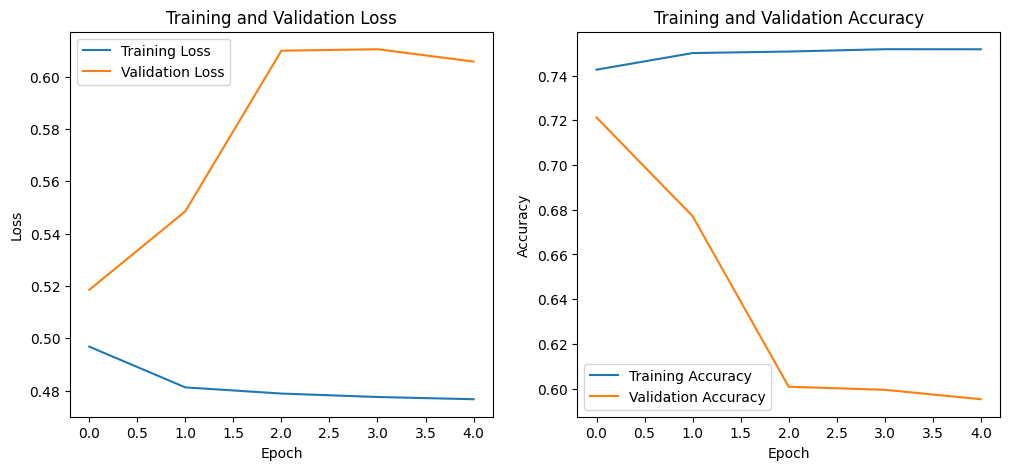

17797/17797 [==============================] - 33s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.54      0.98      0.69    268388
     Class 1       0.94      0.25      0.39    301104

    accuracy                           0.59    569492
   macro avg       0.74      0.61      0.54    569492
weighted avg       0.75      0.59      0.53    569492



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Configure the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

# Plotting training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predicting probabilities of the positive class
y_pred_probs = model.predict(X_test)

# Converting probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generating and printing the classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print(report)


Epoch 1/10
12013/12013 [==============================] - 56s 4ms/step - loss: 0.5460 - accuracy: 0.7250 - val_loss: 0.5780 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/10
12013/12013 [==============================] - 38s 3ms/step - loss: 0.5170 - accuracy: 0.7403 - val_loss: 0.6494 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 3/10
12013/12013 [==============================] - 38s 3ms/step - loss: 0.5153 - accuracy: 0.7412 - val_loss: 0.6262 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 4/10
12013/12013 [==============================] - 39s 3ms/step - loss: 0.5040 - accuracy: 0.7444 - val_loss: 0.6496 - val_accuracy: 0.5350 - lr: 2.0000e-04


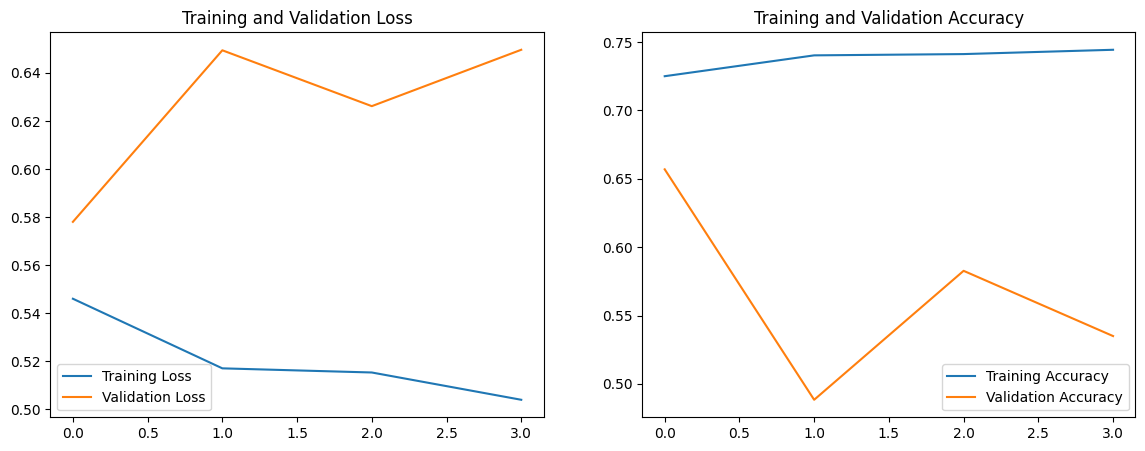

17797/17797 [==============================] - 32s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.58      0.93      0.72    268388
     Class 1       0.87      0.41      0.56    301104

    accuracy                           0.66    569492
   macro avg       0.73      0.67      0.64    569492
weighted avg       0.74      0.66      0.63    569492



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define your model architecture with a reduced capacity and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Configure the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train, y_train,
    epochs=10,  # Adjust the number of epochs if necessary
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot the training and validation loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Predict on the test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


Epoch 1/10
12013/12013 [==============================] - 49s 4ms/step - loss: 0.5290 - accuracy: 0.7429 - val_loss: 0.4860 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 2/10
12013/12013 [==============================] - 44s 4ms/step - loss: 0.5060 - accuracy: 0.7475 - val_loss: 0.4822 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 3/10
12013/12013 [==============================] - 40s 3ms/step - loss: 0.5050 - accuracy: 0.7477 - val_loss: 0.4840 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 4/10
12013/12013 [==============================] - 55s 5ms/step - loss: 0.5050 - accuracy: 0.7476 - val_loss: 0.4849 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 5/10
12013/12013 [==============================] - 41s 3ms/step - loss: 0.4975 - accuracy: 0.7498 - val_loss: 0.4823 - val_accuracy: 0.7535 - lr: 2.0000e-04


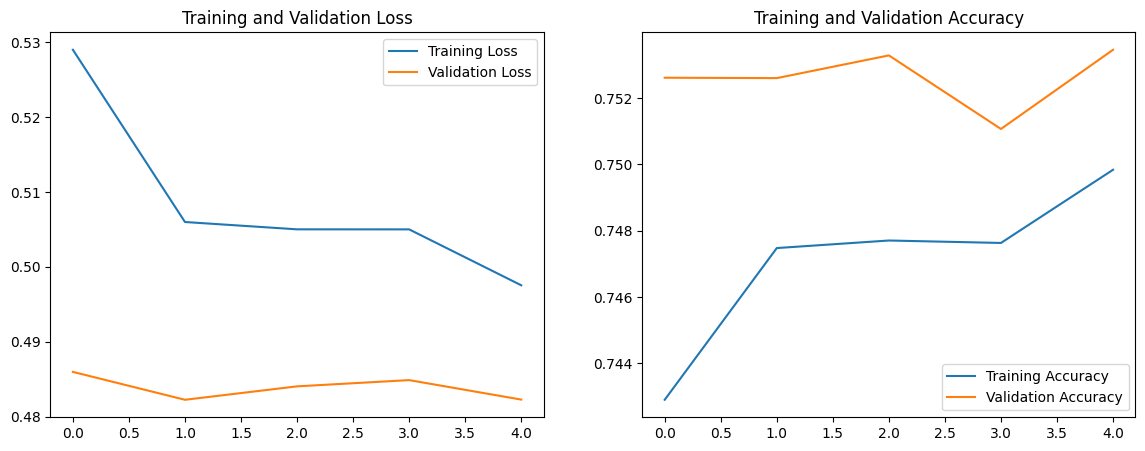

17797/17797 [==============================] - 34s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.75      0.71      0.73    268388
     Class 1       0.75      0.79      0.77    301104

    accuracy                           0.75    569492
   macro avg       0.75      0.75      0.75    569492
weighted avg       0.75      0.75      0.75    569492



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define your model architecture with a reduced capacity and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Configure the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train_normalized, y_train,
    epochs=10,  # Adjust the number of epochs if necessary
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot the training and validation loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Predict on the test data
y_pred_probs = model.predict(X_test_normalized)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


Epoch 1/10
5695/5695 [==============================] - 38s 6ms/step - loss: 0.5387 - accuracy: 0.7402 - val_loss: 0.4834 - val_accuracy: 0.7532
Epoch 2/10
5695/5695 [==============================] - 28s 5ms/step - loss: 0.5022 - accuracy: 0.7486 - val_loss: 0.4804 - val_accuracy: 0.7522
Epoch 3/10
5695/5695 [==============================] - 24s 4ms/step - loss: 0.5011 - accuracy: 0.7488 - val_loss: 0.4821 - val_accuracy: 0.7524
Epoch 4/10
5695/5695 [==============================] - 25s 4ms/step - loss: 0.5012 - accuracy: 0.7488 - val_loss: 0.4802 - val_accuracy: 0.7533
Epoch 5/10
5695/5695 [==============================] - 25s 4ms/step - loss: 0.5005 - accuracy: 0.7485 - val_loss: 0.4811 - val_accuracy: 0.7523
Epoch 6/10
5695/5695 [==============================] - 24s 4ms/step - loss: 0.5005 - accuracy: 0.7489 - val_loss: 0.4800 - val_accuracy: 0.7532
Epoch 7/10
5695/5695 [==============================] - 27s 5ms/step - loss: 0.5004 - accuracy: 0.7486 - val_loss: 0.4807 - val_ac

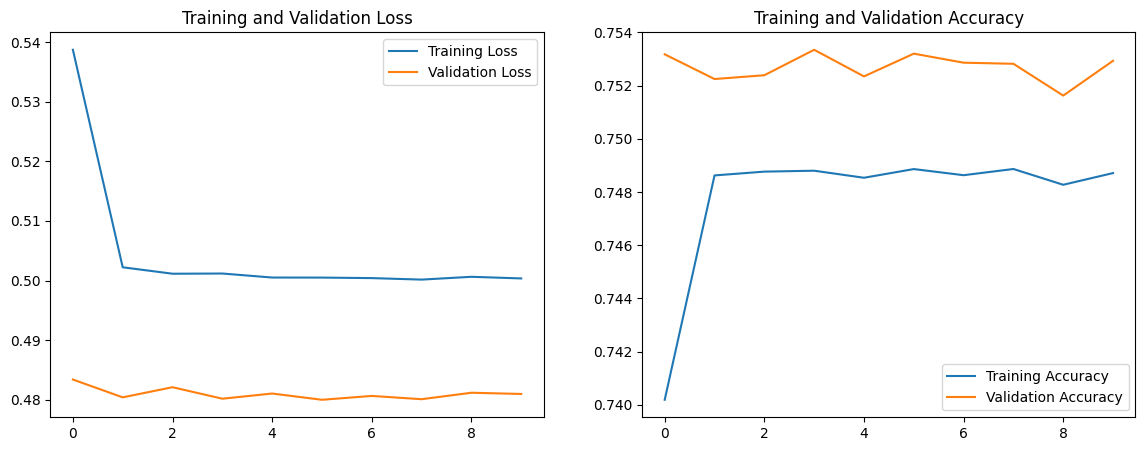

14238/14238 [==============================] - 24s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.77      0.67      0.72    214976
     Class 1       0.74      0.82      0.78    240618

    accuracy                           0.75    455594
   macro avg       0.76      0.75      0.75    455594
weighted avg       0.75      0.75      0.75    455594



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define your model architecture with a reduced capacity and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Configure the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Define early stopping and learning rate reduction
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=2,
#     min_lr=0.0001
# )

# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train_normalized, y_train,
    epochs=10,  # Adjust the number of epochs if necessary
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Plot the training and validation loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Predict on the test data
y_pred_probs = model.predict(X_test_normalized)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


In [ ]:
# # Create a pipeline that first scales the data then applies logistic regression
# model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = model.predict(X_test)

# # Optionally, check the accuracy of the model
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

# # If you want to make probability predictions (useful for ROC curves or other analyses)
# y_prob = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class

In [ ]:
# import pandas as pd

# # Load your dataset
# data = pd.read_csv('/path_to_your_file/sampled_data.csv')

# # Convert 'orderDate' to datetime for easier manipulation
# data['orderDate'] = pd.to_datetime(data['orderDate'])

# # Sorting data to ensure order calculations are correct
# data.sort_values(['customerID', 'orderDate'], inplace=True)

# # 1. Difference in days between the order date of an item and the next order date of the same customer
# data['next_orderDate'] = data.groupby('customerID')['orderDate'].shift(-1)
# data['ac_item_order_date_diff_next'] = (data['next_orderDate'] - data['orderDate']).dt.days

# # 2. Maximum discounted price per article (price - voucherAmount)
# data['discounted_price'] = data['price'] - data['voucherAmount']
# max_discounted_price_per_article = data.groupby('articleID')['discounted_price'].max().rename('max_discounted_price_per_article')
# data = data.merge(max_discounted_price_per_article, on='articleID', how='left')

# # 3. Mean discounted price per article
# mean_discounted_price_per_article = data.groupby('articleID')['discounted_price'].mean().rename('mean_discounted_price_per_article')
# data = data.merge(mean_discounted_price_per_article, on='articleID', how='left')

# # 4. Mean quantity of items per order for each customer
# mean_order_cpr_item_quantity_per_customer = data.groupby('customerID')['quantity'].mean().rename('mean_order_cpr_item_quantity_per_customer')
# data = data.merge(mean_order_cpr_item_quantity_per_customer, on='customerID', how='left')

# # 5. Ratio of current purchase quantity to the mean purchase quantity for the customer
# data['cpr_item_quantity_ratio_per_customer'] = data['quantity'] / data['mean_order_cpr_item_quantity_per_customer']

# # 6. Ratio of item quantity to total items in the order for the same article
# data['total_quantity_per_order'] = data.groupby('orderID')['quantity'].transform('sum')
# data['quantity_ratio_per_order_size_article'] = data['quantity'] / data['total_quantity_per_order']

# # 7. Additional feature if clarified

# # 8. Total quantity of items in the current order
# data['cpr_item_quantity_per_order'] = data['total_quantity_per_order']

# # 9. Total original price (before discounts) of the items in the order
# data['original_price_per_order'] = data.groupby('orderID')['price'].transform('sum')

# # 10. Price per customer per date
# data['price_per_cust_date'] = data.groupby(['customerID', 'orderDate'])['price'].transform('sum')

# # Now you can save or use your enriched dataset
# # data.to_csv('/path_to_your_file/enriched_data.csv', index=False)
